<a href="https://colab.research.google.com/github/datajoedata/mortalidade_populacao_negra_e_parda_brasil/blob/main/EDA_mort_pop_negra_br.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parte I: Apresentação**  

Este notebook apresenta uma análise exploratória da mortalidade por causas violentas na população negra no Brasil. Os dados utilizados foram obtidos a partir do projeto Monitor Rosa e pertencem a ABRALE, que oferece acesso às informações do SUS e no caso específico, do Sistema Único de Mortalidade (SIM).

O objetivo principal é explorar padrões e tendências relacionados às causas externas de mortalidade, como homicídios, intervenções legais e outros eventos violentos que afetam desproporcionalmente a população negra. A análise foca em identificar aspectos sociodemográficos e temporais que possam evidenciar desigualdades estruturais e auxiliar na formulação de políticas públicas para mitigar esses impactos.

Neste contexto, foram considerados:

Causas externas de morte baseadas na CID-10 (Capítulo XX).
Raça/Cor dos indivíduos, com destaque para as classificações Preta e Parda.
Outros fatores como idade, sexo, localidade, e ano/mês do óbito.
Por meio desta análise, busca-se compreender a dimensão do problema e fornecer insights para discussões futuras.

### **1.1 -  Fonte de Dados**:

Os dados utilizados neste notebook foram coletados por meio de scripts que acessam os servidores do Sistema Único de Saúde (SUS) por protocolos HTTP. Esses dados são extraídos e armazenados em um Delta Lake no google drive
### (**Para mais informações sobre a extração dos arquivos checar este [repositório](https://github.com/heber-augusto/devops-pysus-get-files)**).


### **1.2 - Dados do Sistema Único de Mortalidade(SIM)**:

Os arquivos manipulados neste notebook se baseiam nos dados provenientes do Sistema de Informações sobre Mortalidade (SIM). Esse sistema abriga informações relacionadas a óbitos registrados em todo o Brasil, juntamente com diversos indicadores associados. Cada observação ou "registro" deste dataset representa uma Declaração de Óbito ou (DO).   

### **1.3 - Objetivos Específicos**:

A finalidade deste notebook é realizar uma análise exploratória de dados, com enfoque na mortalidade da população negra no Brasil. Isso inclui filtrar e analisar dados relevantes para fornecer insights que possam  para a compreensão e o enfrentamento dessa questão de saúde.

In [1]:
pip install matplotlib geobr cartopy matplotlib-scalebar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 60.5 MB/s eta 0:00:00


In [2]:
import geopandas as gpd
from geobr import read_municipality
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Parte II: Configuração do ambiente e carregamento do catálogo**  


## 2.1 - Escolha do ambiente

In [4]:
import os

if os.path.isfile('/content/monitor-rosa-leitura.json'):
    datalake_mode = 'leitura'
    %env SERVICE_ACCOUNT_USER=acesso-leitura@monitor-rosa.iam.gserviceaccount.com
    %env SERVICE_ACCOUNT_JSON=/content/monitor-rosa-leitura.json
elif os.path.isfile('/content/monitor-rosa-escrita.json'):
    datalake_mode = 'escrita'
    %env SERVICE_ACCOUNT_USER=acesso-escrita@monitor-rosa.iam.gserviceaccount.com
    %env SERVICE_ACCOUNT_JSON=/content/monitor-rosa-escrita.json
else:
    assert(os.path.isdir('/content/drive/Shareddrives/monitor-rosa-gold') == True)
    datalake_mode = 'shared_drive'
    %env SERVICE_ACCOUNT_USER=''
    %env SERVICE_ACCOUNT_JSON=''
datalake_mode

env: SERVICE_ACCOUNT_USER=''
env: SERVICE_ACCOUNT_JSON=''


'shared_drive'

In [5]:
!rm -r sus-kpis-analysis
!git clone https://github.com/heber-augusto/sus-kpis-analysis.git

rm: cannot remove 'sus-kpis-analysis': No such file or directory
Cloning into 'sus-kpis-analysis'...
remote: Enumerating objects: 1768, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1768 (delta 126), reused 279 (delta 111), pack-reused 1464 (from 1)
Receiving objects: 100% (1768/1768), 4.72 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (827/827), done.


## 2.2 - Instalação de libs Python, inicialização de variáveis de ambiente e configuração/instalação do Spark

In [6]:
!pip install -r /content/sus-kpis-analysis/sia/etls/requirements.txt

%env PYTHONHASHSEED=1234
%env JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
%env SPARK_HOME=/content/spark-3.4.4-bin-hadoop3
%env SPARK_VERSION=3.4.4

!source /content/sus-kpis-analysis/sia/etls/bin/setup_spark_env.sh '/content/'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.4-py2.py3-none-any.whl size=311905460 sha256=8228336809782def112dec7465e2c2932058bb2acbfd58c378374bb437789183
  Stored in directory: /root/.cache/pip/wheels/9a/b2/e2/382460beb13a6ab29568e5e7807561604442b9556b385771ba
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3
env: PYTHONHASHSEED=1234
env: JAVA_HOME=/usr/lib/jvm/java-8-openjdk-amd64
env: SPARK_HOME=/content/spark-3.4.4-bin-hadoop3
env: SPARK_VERSION=3.4.4
starting spark env setup 
installing and downloading packages
W: Skipping acquire of configured file 'main/source/Sources

In [7]:
if datalake_mode != 'shared_drive':
    %env XDG_CONFIG_HOME=/content/datalake
    !source /content/sus-kpis-analysis/sia/etls/bin/install-google-drive-ocamlfuse.sh
    !source /content/sus-kpis-analysis/sia/etls/bin/mount_google_drive_v2.sh '/content/datalake' $SERVICE_ACCOUNT_USER '0ABIY-a4qrdY9Uk9PVA' 'monitor-rosa-bronze' $SERVICE_ACCOUNT_JSON '/content'
    !source /content/sus-kpis-analysis/sia/etls/bin/mount_google_drive_v2.sh '/content/datalake' $SERVICE_ACCOUNT_USER '0ALl0owLNr53oUk9PVA' 'monitor-rosa-silver' $SERVICE_ACCOUNT_JSON '/content'
    !source /content/sus-kpis-analysis/sia/etls/bin/mount_google_drive_v2.sh '/content/datalake' $SERVICE_ACCOUNT_USER '0AMHp9pBeLvZiUk9PVA' 'monitor-rosa-gold' $SERVICE_ACCOUNT_JSON '/content'

## 2.3 - Inicializa variáveis de acesso ao delta lake criado no google storage

- Local do arquivo de credencial do storage, diretorio do warehouse e path do spark:


> O caminho do warehouse pode ser alterado em caso de testes de escritas locais.

> O caminho do spark é setado pelo script de configuração

In [8]:
import os

lake_prefix = "temp-output"

if datalake_mode in ('leitura','shared_drive',):
    warehouse_dir = f"/content/datalake/{lake_prefix}/"

if datalake_mode == 'escrita':
    warehouse_dir = f"/content/datalake/"

spark_path = os.getenv('SPARK_HOME')
spark_path

'/content/spark-3.4.4-bin-hadoop3'

## 2.4 - Inclusão da pasta do repositório no python path

Procedimento permite que funções e classes presentes no repositório sejam utilizadas

In [9]:
import sys
sys.path.append('/content/sus-kpis-analysis')
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/content/sus-kpis-analysis']

## 2.5 - Importação de funções utilizadas pelo código



In [10]:
from sia.etls.lib.catalog_loader import DeltaLakeDatabaseFsCreator, load_entire_catalog_fs, load_entire_catalog_fs_v2
from sia.etls.lib.table_utilities import vacuum_tables_from_database, table_exists
from sia.etls.lib.fs_spark_session import create_fs_spark_session
from sia.etls.lib.bronze_files_utilities import get_pending_files_from_bronze
from sia.etls.lib.delta_table_creators import ParquetToDelta

## 2.6 -  Cria Sessão Spark conectada ao Delta Lake presente no Google Storage

In [11]:
spark = create_fs_spark_session(
    warehouse_dir=warehouse_dir,
    spark_path=spark_path
)

## 2.7 - Refresh do catálogo para utilizar consultas

In [12]:
zone_names = ['monitor-rosa-bronze', 'monitor-rosa-silver', 'monitor-rosa-gold']
if datalake_mode in ('leitura', 'escrita'):
    zone_paths = [f'/content/datalake/{zone_name}/databases' for zone_name in zone_names]
else:
    zone_paths = [f'/content/drive/Shareddrives/{zone_name}/databases' for zone_name in zone_names]


# Carrega catalogo de banco de dados, na zona bronze
table_filter =  None #['demografia_municipios', 'dores']            #->>>> Utilizando 'None' como argumento aqui permite listar todas as tabelas.
database_filter = ['sim_bronze.db','cancer_data.db', ]       #->>>> Utilizando 'None' como argumento permite listar todos os bancos de dados.

for databases_path in zone_paths:
    load_entire_catalog_fs_v2(
        spark_session = spark,
        databases_path = databases_path,
        use_db_folder_path=(datalake_mode == 'escrita'),
        database_filter=database_filter,
        table_filter=table_filter
    )

['sia_bronze.db', 'cnes_bronze.db', 'sih_bronze.db', 'sim_bronze.db']
Banco de dados sim_bronze criado.
listando conteúdos do caminho /content/drive/Shareddrives/monitor-rosa-bronze/databases e database sim_bronze
prefix: /content/drive/Shareddrives/monitor-rosa-bronze/databases/sim_bronze.db/
table_list: ['dores']
Tabela dores criada
Tabela dores criada com comando CREATE TABLE IF NOT EXISTS sim_bronze.dores USING delta LOCATION '/content/drive/Shareddrives/monitor-rosa-bronze/databases/sim_bronze.db/dores'
Recriação das tabelas concluída.
['cancer_data.db', 'ibge_silver.db']
Banco de dados cancer_data criado.
listando conteúdos do caminho /content/drive/Shareddrives/monitor-rosa-silver/databases e database cancer_data
prefix: /content/drive/Shareddrives/monitor-rosa-silver/databases/cancer_data.db/
table_list: ['aq_filtered', 'ar_filtered', 'dados_estados_mensal', 'dados_municipios_mensal', 'pacientes', 'procedimentos', 'procedimentos_e_pacientes', 'demografia_municipios', 'cadastro_

# **Parte III: Exemplo de como listar e acessar os bancos de dados e tabelas**  


#### 3.1 - (Comando lista e visualiza todos os bancos de dados existentes no projeto)

In [12]:
databases = spark.sql(f"SHOW DATABASES;")
databases.show()

+-----------+
|  namespace|
+-----------+
|cancer_data|
|    default|
| sim_bronze|
+-----------+



#### 3.2 - (Comando para iterar por todos os bancos de dados e visualizar todas as tabelas existentes em cada banco de dados no projeto)

In [13]:
for row in databases.collect():
    spark.sql(f"SHOW TABLES FROM {row['namespace']};").show(truncate=False)

+-----------+-------------------------+-----------+
|namespace  |tableName                |isTemporary|
+-----------+-------------------------+-----------+
|cancer_data|aq_filtered              |false      |
|cancer_data|ar_filtered              |false      |
|cancer_data|cadastro_municipios      |false      |
|cancer_data|dados_estados_mensal     |false      |
|cancer_data|dados_municipios_mensal  |false      |
|cancer_data|demografia_municipios    |false      |
|cancer_data|pacientes                |false      |
|cancer_data|procedimentos            |false      |
|cancer_data|procedimentos_e_pacientes|false      |
+-----------+-------------------------+-----------+

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+

+----------+---------+-----------+
|namespace |tableName|isTemporary|
+----------+---------+-----------+
|sim_bronze|dores    |false      |
+----------+---------+-----------+



# **Parte IV: Primeiras visualizações**  


### **4.1 - Primeira visualização de arquivos do Sistema de Informações sobre Mortalidade(SIM)**


In [14]:
df_prim_viz_sim = spark.sql("SELECT * FROM sim_bronze.dores LIMIT 3").show()

+--------+--------+--------+---------+-------+--------+-----+----+-------+------+---+------+---------+---------+-------+--------+----------+----------+--------+------+-------+----------+----------+--------+--------+-----+----------+----+---------+----------+---------+-----+--------+---------+------+------+------+------+-------+--------+--------+----------+---------+--------+-----+-----+----------+----------+----------+---------+--------+---------+--------+------+--------------------+----------------------+--------------------+-------------------+----------+----------+------+----------+-------+----------+---------+-------+----------+----------+----------+----------+----------+----------+---------+--------+-------+----------+--------+--------+--------+--------+---------+----------+----------+----------+----+----------+----------+----------+----------+---------+-----------------+----------+----------+----------+----------+------+----------+----------+---------+---------+--------+
|CONTADO

### **4.2 - Primeira visualização de arquivos da tabela "demografia_municipios"**

In [15]:
df_prim_viz_demo = spark.sql("""SELECT * FROM cancer_data.demografia_municipios LIMIT 3""").show()

+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|codigo_sexo|valor_sexo|codigo_situacao|valor_situacao|codigo_local|          nome_local| ano|populacao|faixa_idade|
+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+
|          4|    Homens|              0|         Total|     1100015|Alta Floresta D'O...|2010|    12656|      Total|
|          4|    Homens|              0|         Total|     1100023|      Ariquemes - RO|2010|    45543|      Total|
|          4|    Homens|              0|         Total|     1100031|         Cabixi - RO|2010|     3266|      Total|
+-----------+----------+---------------+--------------+------------+--------------------+----+---------+-----------+



### **4.3 - Algumas definições:**
- A coluna 'DTOBITO' da tabela SIM será utilizada como marcação temporal. [Clique aqui para mais informações](https://colab.research.google.com/github/datajoedata/eda-mortalidade-cancer-mama-sus-clusterizacao/blob/main/eda_obitos.ipynb#scrollTo=jswjNElsg4Zg)


# **Parte V: Filtragem dos Óbitos**




 ## 5.1 - **Utilizando códigos Cid-10 para filtrar óbitos relacionados a causas violentas.**
[Se você não sabe o que é o CID-10, clique aqui para breve explicação ->](https://colab.research.google.com/github/datajoedata/eda-mortalidade-cancer-mama-sus-clusterizacao/blob/main/eda_obitos.ipynb#scrollTo=GAhPff2HCQf8&line=3&uniqifier=1)


- W50-W64 - Agressões causadas por outras pessoas.
- X85-Y09 - Agressões intencionais (homicídios).
- Y35 - Intervenção legal (ex.: ação policial).
- Y36 - Operações de guerra.
- Y20-Y29 - Lesões por armas ou quedas com intenção desconhecida.

In [13]:
# Intervalos de códigos
intervalos = {
    'W50-W64': range(50, 65),  # Inclui de W50 a W64
    'X85-Y09': range(85, 100),  # Inclui de X85 a X99
    'Y20-Y29': range(20, 30),   # Inclui de Y20 a Y29
}

# Expandir os intervalos
cid_filter = []
for prefixo, valores in intervalos.items():
    letra = prefixo[0]  # Pega a letra inicial (W, X ou Y)
    cid_filter.extend([f"{letra}{str(valor).zfill(2)}" for valor in valores])

# Adicionar os valores individuais (Y35 e Y36)
cid_filter.extend(['Y35', 'Y36'])

# Gerando a string SQL com os códigos da lista
cid_filter_sql = ", ".join([f"'{cid}'" for cid in cid_filter])

## 5.2 - Colunas que serão utilizadas:

##### **1. Causa básica do óbito (CID-10):**
- **Filtro:** Causas externas de morbidade e mortalidade (Capítulo XX da CID-10, códigos iniciando com **V**, **W**, **X** e **Y**).

##### **2. Raça/Cor (RACACOR):**
- Diferencia os óbitos em diferentes etnias

##### **3. Sexo (SEXO):**

##### **4. Idade (IDADE):**


##### **5. Local do óbito ou residência (CODMUNOCOR):**


##### **6. Ano e Mês do óbito (DTOBITO):**


## 5.3 - Filtragem da Tabela DORES (Registros Óbitos)


In [14]:
from pyspark.sql.functions import monotonically_increasing_id
# Carregar o DataFrame original
df_org= spark.table("sim_bronze.dores").withColumn("unique_id", monotonically_increasing_id())

# Aplicando o filtro usando a string SQL gerada
df_filt_mort = df_org.filter(
    f"SUBSTRING(CAUSABAS, 1, 3) IN ({cid_filter_sql})"
)

# Removendo duplicatas usando o índice único
df_filt_mort_no_duplicates = df_filt_mort.dropDuplicates(["unique_id"])

# Selecionando as colunas relevantes (ajustando para as disponíveis no esquema)
df_filt_mort_final = df_filt_mort_no_duplicates.select(
    "CAUSABAS",
    "RACACOR",
    "DTOBITO",
    "SEXO",
    "IDADE",
    "CODMUNOCOR",
    "ESC",
    "CONTADOR"
)

df_filt_mort_final.count()

644236

## 5.4 - Tabela Demografia




In [15]:
df_demografia = spark.sql("""SELECT * FROM cancer_data.demografia_municipios LIMIT """)

# Parte VI:  Limpeza dos dados

###  6.1 - Transformando coluna idade da tabela SIM para anos

In [16]:
from pyspark.sql.functions import col, substring, when

# Garantir que a coluna 'IDADE' tenha exatamente 3 caracteres
df_transformado = df_filt_mort_final.withColumn('IDADE', substring(col('IDADE'), 1, 3))

# Extrair 'unidade' e 'quantidade' da coluna 'IDADE'
df_transformado = df_transformado.withColumn('unidade', substring(col('IDADE'), 1, 1).cast('int'))
df_transformado = df_transformado.withColumn('quantidade', substring(col('IDADE'), 2, 2).cast('int'))

# Aplicar a lógica para calcular 'idade_anos'
df_transformado = df_transformado.withColumn(
    'idade_anos',
    when(col('unidade') == 0, None)  # Idade ignorada
    .when(col('unidade') == 1, col('quantidade') / (24 * 365))  # Horas para anos
    .when(col('unidade') == 2, col('quantidade') / 365)  # Dias para anos
    .when(col('unidade') == 3, col('quantidade') / 12)  # Meses para anos
    .when(col('unidade') == 4, col('quantidade').cast('float'))  # Anos
    .when(col('unidade') == 5, 100 + col('quantidade').cast('float'))  # Mais de 100 anos
    .otherwise(None)  # Outros casos não previstos
)

# Opcional: Remover colunas auxiliares 'unidade' e 'quantidade'
df_transformado = df_transformado.drop('unidade', 'quantidade')

# Mostrar os resultados
df_transformado.select('IDADE', 'idade_anos').show(5)

+-----+----------+
|IDADE|idade_anos|
+-----+----------+
|  436|      36.0|
|  487|      87.0|
|  443|      43.0|
|  461|      61.0|
|  480|      80.0|
+-----+----------+
only showing top 5 rows



## 6.2 - Tratamento de duplicatas

In [17]:
# Contagem de duplicatas

duplicatas = (
    df_transformado.groupBy("CONTADOR")
    .count()
    .filter("count > 1")  # Mostra apenas valores que têm duplicatas
)
duplicatas.show(5)

+--------+-----+
|CONTADOR|count|
+--------+-----+
|    1930|   12|
|    1934|   12|
|    3060|   13|
|    3080|   13|
|    3607|   11|
+--------+-----+
only showing top 5 rows



Remoção duplicatas

In [18]:
# Baseado na coluna 'CONTADOR'
df_filt_mort_final_no_duplicates = df_transformado.dropDuplicates(["CONTADOR"])

df_filt_mort_final_no_duplicates.count()

338129

## 6.3 - Tratamento de valores nulos/vazios

In [19]:
from pyspark.sql.functions import col, sum

# Contar valores nulos e vazios em todas as colunas
resultados_nulos = df_filt_mort_final_no_duplicates.select(
    [
        sum(col(c).isNull().cast("int")).alias(f"{c}_nulos") for c in df_filt_mort_final_no_duplicates.columns
    ]
)

resultados_vazios = df_filt_mort_final_no_duplicates.select(
    [
        sum((col(c) == "").cast("int")).alias(f"{c}_vazios") for c in df_filt_mort_final_no_duplicates.columns
    ]
)

# Mostrar resultados
print("Contagem de valores nulos:")
resultados_nulos.show()

print("Contagem de valores vazios:")
resultados_vazios.show()

Contagem de valores nulos:
+--------------+-------------+-------------+----------+-----------+----------------+---------+--------------+----------------+
|CAUSABAS_nulos|RACACOR_nulos|DTOBITO_nulos|SEXO_nulos|IDADE_nulos|CODMUNOCOR_nulos|ESC_nulos|CONTADOR_nulos|idade_anos_nulos|
+--------------+-------------+-------------+----------+-----------+----------------+---------+--------------+----------------+
|             0|            0|            0|         0|          0|               0|        0|             0|            5821|
+--------------+-------------+-------------+----------+-----------+----------------+---------+--------------+----------------+

Contagem de valores vazios:
+---------------+--------------+--------------+-----------+------------+-----------------+----------+---------------+-----------------+
|CAUSABAS_vazios|RACACOR_vazios|DTOBITO_vazios|SEXO_vazios|IDADE_vazios|CODMUNOCOR_vazios|ESC_vazios|CONTADOR_vazios|idade_anos_vazios|
+---------------+--------------+-----

## 6.4 - Removendo valores nulos e vazios

In [20]:
from pyspark.sql.functions import col

# Criar um DataFrame limpo garantindo que os valores sejam consistentes
df_limpo = (
    df_filt_mort_final_no_duplicates
    .filter((col("RACACOR").isNotNull()) & (col("RACACOR") != ""))  # Remover nulos e vazios de RACACOR
    .filter(col("idade_anos").isNotNull())  # Remover valores nulos de idade_anos
)
df_limpo.show(3)

+--------+-------+--------+----+-----+----------+---+--------+----------+
|CAUSABAS|RACACOR| DTOBITO|SEXO|IDADE|CODMUNOCOR|ESC|CONTADOR|idade_anos|
+--------+-------+--------+----+-----+----------+---+--------+----------+
|    X959|      1|28012014|   2|  412|    355030|  3|       1|      12.0|
|    Y209|      1|17072009|   1|  446|    352720|   |      10|      46.0|
|    X990|      4|07022019|   1|  422|    291550|  2|    1000|      22.0|
+--------+-------+--------+----+-----+----------+---+--------+----------+
only showing top 3 rows



In [21]:
# Contar novamente valores nulos e vazios para RACACOR e idade_anos
count_racacor_null = df_limpo.filter(col("RACACOR").isNull() | (col("RACACOR") == "")).count()
count_idade_anos_null = df_limpo.filter(col("idade_anos").isNull()).count()

print(f"Valores nulos ou vazios restantes em RACACOR: {count_racacor_null}")
print(f"Valores nulos restantes em idade_anos: {count_idade_anos_null}")

Valores nulos ou vazios restantes em RACACOR: 0
Valores nulos restantes em idade_anos: 0


## 6.5 - Tratamento de datatypes

In [22]:
df_limpo.printSchema()

root
 |-- CAUSABAS: string (nullable = true)
 |-- RACACOR: string (nullable = true)
 |-- DTOBITO: string (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- IDADE: string (nullable = true)
 |-- CODMUNOCOR: string (nullable = true)
 |-- ESC: string (nullable = true)
 |-- CONTADOR: string (nullable = true)
 |-- idade_anos: double (nullable = true)



### 6.4.1 - Tratamento da coluna 'DTOBITO'

In [23]:
from pyspark.sql.functions import to_date

# Converter a coluna DTOBITO para DateType
df_limpo = df_filt_mort_final_no_duplicates.withColumn(
    "DTOBITO",
    to_date("DTOBITO", "ddMMyyyy")
)

# Verificar o esquema e os dados
df_limpo.printSchema()
df_limpo.select("DTOBITO").show(10, truncate=False)

root
 |-- CAUSABAS: string (nullable = true)
 |-- RACACOR: string (nullable = true)
 |-- DTOBITO: date (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- IDADE: string (nullable = true)
 |-- CODMUNOCOR: string (nullable = true)
 |-- ESC: string (nullable = true)
 |-- CONTADOR: string (nullable = true)
 |-- idade_anos: double (nullable = true)

+----------+
|DTOBITO   |
+----------+
|2014-01-28|
|2009-07-17|
|2009-02-27|
|2019-02-07|
|2020-04-08|
|2013-04-23|
|2017-10-05|
|2022-09-04|
|2015-09-24|
|2009-11-29|
+----------+
only showing top 10 rows



#**Parte VII: Mortalidade por causas violentas na população negra e parda:**

Checagem do escopo de datas

In [25]:
escopo_datas = df_limpo.selectExpr(
    "MIN(DTOBITO) AS data_minima",
    "MAX(DTOBITO) AS data_maxima"
).collect()

data_minima, data_maxima = escopo_datas[0]['data_minima'], escopo_datas[0]['data_maxima']
print(f"Data mínima: {data_minima}")
print(f"Data máxima: {data_maxima}")

Data mínima: 2008-01-01
Data máxima: 2022-12-31


#

# **Mortalidade por causas violentas por grupo étnico:**

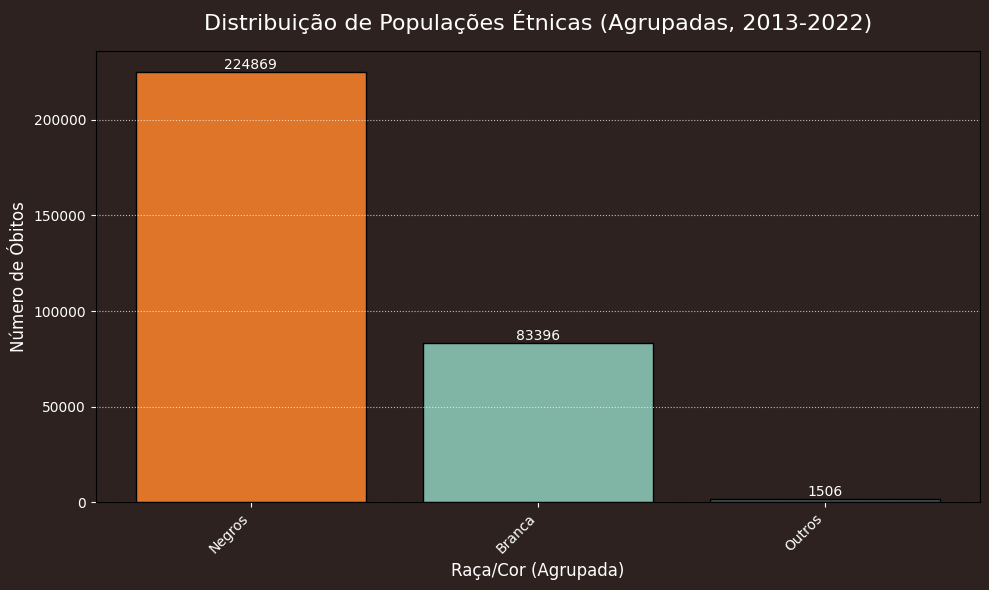

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter o DataFrame Spark para pandas
df_pandas = df_limpo.toPandas()

# Mapear os códigos de RACACOR para labels
mapa_racacor = {
    '1': 'Branca',
    '2': 'Preta',
    '3': 'Amarela',
    '4': 'Parda',
    '5': 'Indígena',
    '9': 'Ignorado'
}

# Mapear a coluna 'RACACOR' para labels
df_pandas['RACACOR_LABEL'] = df_pandas['RACACOR'].map(mapa_racacor)

# Converter 'DTOBITO' para datetime e calcular anos
df_pandas['DTOBITO'] = pd.to_datetime(df_pandas['DTOBITO'], format='%Y-%m-%d', errors='coerce')
df_pandas = df_pandas.dropna(subset=['DTOBITO'])
df_pandas['ANO'] = df_pandas['DTOBITO'].dt.year

# Filtrar apenas o range de anos de 2013 até 2022
df_pandas = df_pandas[df_pandas['ANO'].between(2013, 2022)]

# Agrupar Pretos e Pardos como "Negros" e Amarelos e Indígenas como "Outros"
df_pandas['RACACOR_AGRUPADO'] = df_pandas['RACACOR_LABEL'].replace({
    'Preta': 'Negros',
    'Parda': 'Negros',
    'Amarela': 'Outros',
    'Indígena': 'Outros'
})

# Agrupar dados para o gráfico
distribuicao_etnica_agrupada = df_pandas['RACACOR_AGRUPADO'].value_counts()

# Paleta de cores ajustada
colors = ['#df7529','#80b5a6', '#445454']  # Cores para Brancos, Negros (alaranjado), Outros

# Criar o gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#2d221f')  # Fundo escuro na figura
ax.set_facecolor('#2d221f')  # Fundo escuro no gráfico

bars = ax.bar(distribuicao_etnica_agrupada.index, distribuicao_etnica_agrupada.values, color=colors[:len(distribuicao_etnica_agrupada)], edgecolor='black')

# Personalizar o gráfico
ax.set_title('Distribuição de Populações Étnicas (Agrupadas, 2013-2022)', fontsize=16, color='white', pad=15)
ax.set_xlabel('Raça/Cor (Agrupada)', fontsize=12, color='white')
ax.set_ylabel('Número de Óbitos', fontsize=12, color='white')
ax.tick_params(colors='white')
ax.grid(axis='y', linestyle=':', alpha=0.7, color='white')  # Linhas pontilhadas

# Ajustar as labels no eixo x
ax.set_xticks(range(len(distribuicao_etnica_agrupada.index)))
ax.set_xticklabels(distribuicao_etnica_agrupada.index, rotation=45, ha='right', fontsize=10, color='white')

# Adicionar rótulos nas barras
for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10,
            f'{int(bar.get_height())}', ha='center', va='bottom', color='white', fontsize=10)

plt.tight_layout()
plt.show()



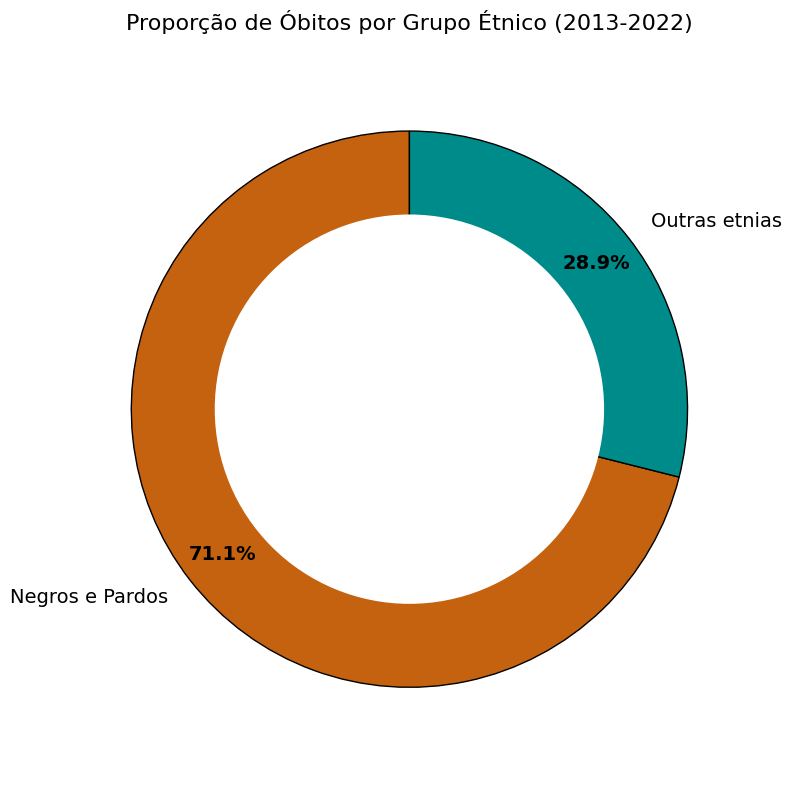

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter o DataFrame PySpark para pandas
df_pandas_pp = df_limpo.toPandas()

# Mapear os códigos de RACACOR para labels
mapa_racacor = {
    '1': 'Branca',
    '2': 'Preta',
    '3': 'Amarela',
    '4': 'Parda',
    '5': 'Indígena',
    '9': 'Ignorado'
}

df_pandas_pp['RACACOR_LABEL'] = df_pandas_pp['RACACOR'].map(mapa_racacor)

# Criar a coluna 'POPULACAO' categorizando em 'Negros e Pardos' e 'Outras etnias'
df_pandas_pp['POPULACAO'] = df_pandas_pp['RACACOR_LABEL'].apply(
    lambda x: 'Negros e Pardos' if x in ['Preta', 'Parda'] else 'Outras etnias'
)

# Converter 'DTOBITO' para datetime e calcular anos
df_pandas_pp['DTOBITO'] = pd.to_datetime(df_pandas_pp['DTOBITO'], format='%Y-%m-%d', errors='coerce')
df_pandas_pp = df_pandas_pp.dropna(subset=['DTOBITO'])
df_pandas_pp['ANO'] = df_pandas_pp['DTOBITO'].dt.year

# Filtrar apenas o range de anos de 2013 até 2022
df_pandas_pp = df_pandas_pp[df_pandas_pp['ANO'].between(2013, 2022)]

# Calcular o total de mortes por grupo
mortes_por_grupo = df_pandas_pp['POPULACAO'].value_counts()

# Definir as cores para o gráfico de rosca com tons mais vibrantes e metálicos
colors = ['#C46210', '#008B8B']  # Tons mais vibrantes: Dark Cyan e Alloy Orange

# Criar o gráfico de rosca
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    mortes_por_grupo.values,
    labels=mortes_por_grupo.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'},  # Linha preta delimitando os segmentos
    textprops={'fontsize': 14, 'color': 'black'}
)

# Criar um círculo branco no centro para transformar em gráfico de rosca
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Assegura que o gráfico seja um círculo perfeito
ax.axis('equal')

# Adicionar título
plt.title('Proporção de Óbitos por Grupo Étnico (2013-2022)', fontsize=16)

# Ajustar a posição das labels
plt.setp(autotexts, size=14, weight="bold")

# Mostrar o gráfico
plt.tight_layout()
plt.show()


# Parte VIII: Óbitos violentos por 100.000 habitantes na população Negra e Parda


In [31]:
# Importar bibliotecas necessárias
from pyspark.sql.functions import col, substring, count, sum as Fsum, round, when, lit, first

# Verificar se 'codigo_local' está presente
if 'codigo_local' in df_demografia.columns:
    # Preparar o dataframe de demografia
    df_demografia = df_demografia.withColumn("CODMUNOCOR", substring(col("codigo_local").cast("string"), 1, 6))
else:
    print("A coluna 'codigo_local' não está presente em df_demografia.")
    print("As colunas disponíveis são:", df_demografia.columns)


if 'CODMUNOCOR' in df_demografia.columns:
    # Selecionar apenas as colunas necessárias
    df_demografia = df_demografia.select("CODMUNOCOR", "nome_local", "populacao", "ano")

    # Filtrar o ano da população para corresponder aos dados de óbitos
    populacao_ano = 2010
    df_demografia = df_demografia.filter(col("ano") == populacao_ano)

    # Agregar a população por município
    df_demografia_agg = df_demografia.groupBy("CODMUNOCOR").agg(
        first("nome_local").alias("nome_local"),
        Fsum("populacao").alias("populacao_total")
    )

    # Calcular o número de óbitos por município
    df_obitos_por_municipio = (
        df_limpo.groupBy("CODMUNOCOR")
        .agg(count("*").alias("numero_obitos"))
    )

    # Unir os dataframes de óbitos e demografia agregada com base no CODMUNOCOR
    df_resultado = df_obitos_por_municipio.join(
        df_demografia_agg,
        on="CODMUNOCOR",
        how="inner"
    )

    # Calcular a taxa de mortalidade por 100.000 habitantes
    df_resultado = df_resultado.withColumn(
        "taxa_mortalidade",
        round((col("numero_obitos") / col("populacao_total")) * 100000, 2)
    )

    # Selecionar e ordenar as colunas
    df_resultado = df_resultado.select(
        "CODMUNOCOR",
        "nome_local",
        "numero_obitos",
        "populacao_total",
        "taxa_mortalidade"
    ).orderBy(col("taxa_mortalidade").desc())

    # Mostrar os resultados
    df_resultado.show(truncate=False)


+----------+-----------------------------+-------------+---------------+----------------+
|CODMUNOCOR|nome_local                   |numero_obitos|populacao_total|taxa_mortalidade|
+----------+-----------------------------+-------------+---------------+----------------+
|293320    |Vera Cruz - BA               |318          |91388.0        |347.97          |
|291920    |Lauro de Freitas - BA        |1301         |394691.0       |329.62          |
|293070    |Simões Filho - BA            |900          |290624.0       |309.68          |
|292100    |Mata de São João - BA        |291          |98622.0        |295.07          |
|231250    |São João do Jaguaribe - CE   |54           |18581.0        |290.62          |
|290570    |Camaçari - BA                |1695         |595432.0       |284.67          |
|291610    |Itaparica - BA               |142          |50418.0        |281.65          |
|520005    |Abadia de Goiás - GO         |47           |16727.0        |280.98          |
|291855   

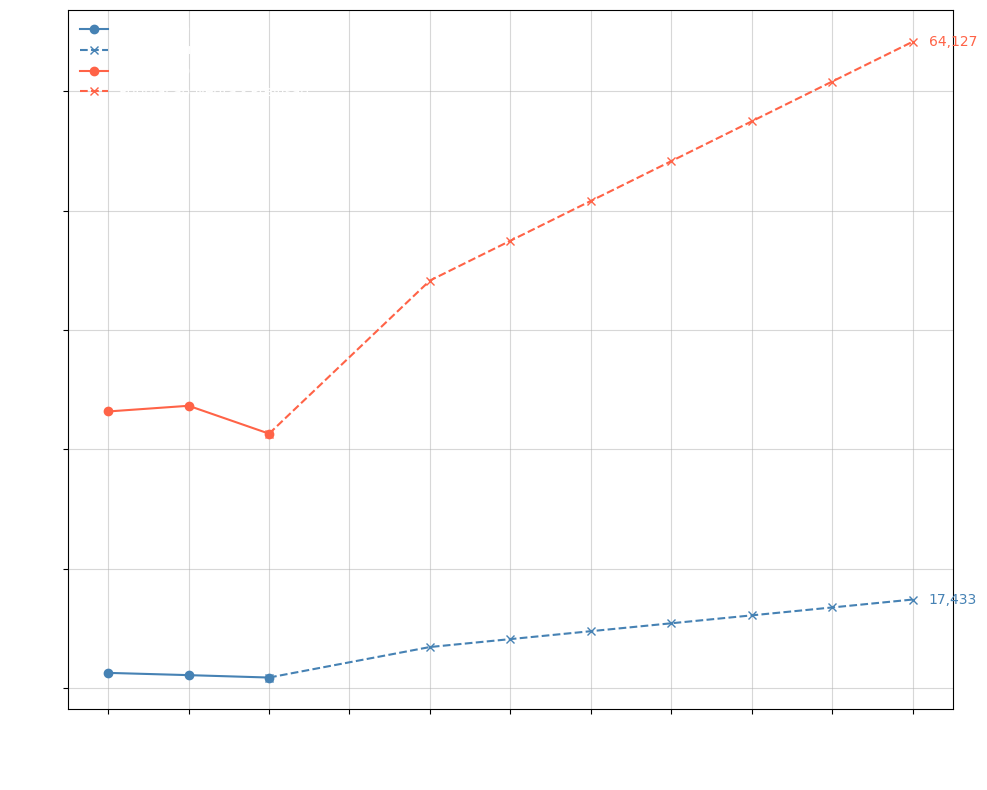

In [47]:
# Plotar o gráfico de linhas com fundo transparente, intervalo de anos ajustado (2020-2030) e legendas brancas em negrito
plt.figure(figsize=(10, 8), facecolor='none')  # Fundo da figura transparente

# Definir cores para as linhas
cores = {'População Negra': '#FF6347', 'Outras': '#4682B4'}  # Cores diferenciadas

for pop in obitos_por_ano_pop.columns:
    # Dados reais (apenas 2020 a 2023)
    anos_reais_plot = obitos_por_ano_pop.index[obitos_por_ano_pop.index >= 2020]
    obitos_reais_plot = obitos_por_ano_pop.loc[obitos_por_ano_pop.index >= 2020, pop]

    # Previsões
    anos_predicao = anos_futuros.flatten()
    obitos_predicao = previsoes[pop]

    # Plotar dados reais
    plt.plot(anos_reais_plot, obitos_reais_plot, label=f'{pop} - Dados Reais', color=cores[pop], marker='o')

    # Plotar previsões com continuação
    plt.plot([anos_reais_plot[-1], *anos_predicao],
             [obitos_reais_plot.iloc[-1], *obitos_predicao],
             label=f'{pop} - Previsão', color=cores[pop], linestyle='--', marker='x')

    # Adicionar rótulo ao lado do ponto de 2030
    plt.text(anos_predicao[-1] + 0.2, obitos_predicao[-1],
             f'{int(obitos_predicao[-1]):,}',
             fontsize=10, color=cores[pop], va='center')

# Ajustar os ticks do eixo x para mostrar apenas anos inteiros de 2020 a 2030
anos_todos = np.arange(2020, 2031)  # Anos de 2020 a 2030
plt.xticks(anos_todos, rotation=45, color='white', fontweight='bold')  # Legenda do eixo x em branco e negrito

# Ajustar o eixo Y (número total de óbitos) com cor branca e negrito
plt.yticks(color='white', fontweight='bold')



plt.legend(facecolor='none', frameon=False, fontsize=10, labelcolor='white')  # Legenda em branco
plt.grid(True, alpha=0.5)  # Grade levemente transparente
plt.tight_layout()

# Tornar o fundo do gráfico transparente
ax = plt.gca()
ax.set_facecolor('none')  # Fundo do eixo transparente

# Mostrar o gráfico
plt.show()



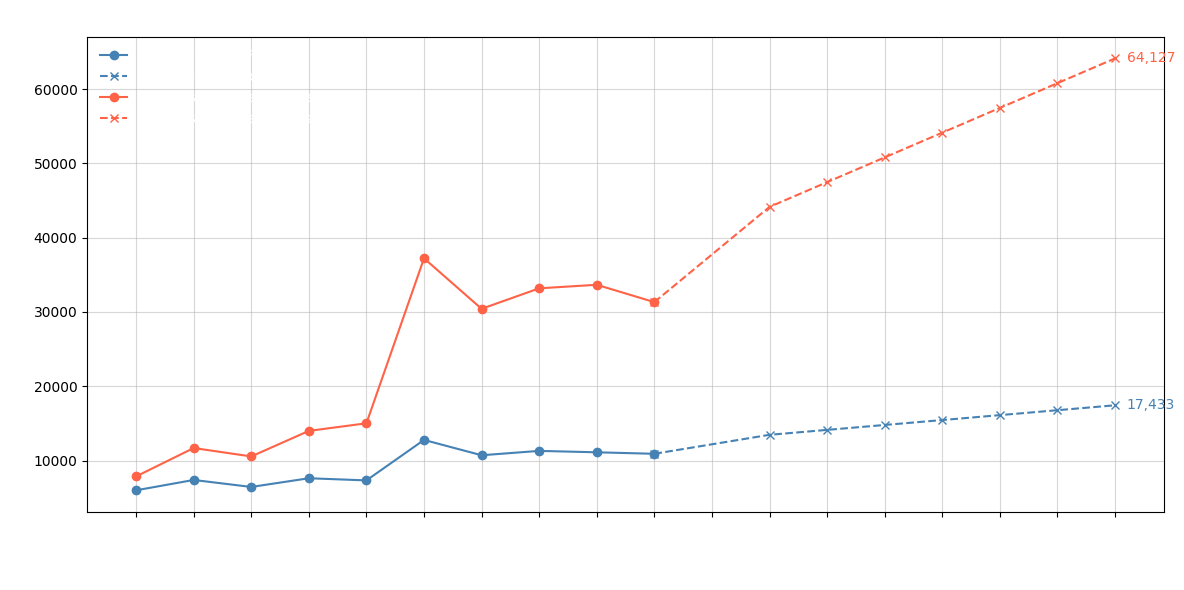

In [43]:
# Plotar o gráfico de linhas com fundo transparente e legendas brancas
plt.figure(figsize=(12, 6), facecolor='none')  # Fundo da figura transparente

# Definir cores para as linhas
cores = {'População Negra': '#FF6347', 'Outras': '#4682B4'}  # Cores diferenciadas

for pop in obitos_por_ano_pop.columns:
    # Dados reais
    anos_reais_plot = obitos_por_ano_pop.index
    obitos_reais_plot = obitos_por_ano_pop[pop]

    # Previsões
    anos_predicao = anos_futuros.flatten()
    obitos_predicao = previsoes[pop]

    # Plotar dados reais
    plt.plot(anos_reais_plot, obitos_reais_plot, label=f'{pop} - Dados Reais', color=cores[pop], marker='o')

    # Plotar previsões com continuação
    plt.plot([anos_reais_plot[-1], *anos_predicao],
             [obitos_reais_plot.iloc[-1], *obitos_predicao],
             label=f'{pop} - Previsão', color=cores[pop], linestyle='--', marker='x')

    # Adicionar rótulo ao lado do ponto de 2030
    plt.text(anos_predicao[-1] + 0.2, obitos_predicao[-1],
             f'{int(obitos_predicao[-1]):,}',
             fontsize=10, color=cores[pop], va='center')

# Ajustar os ticks do eixo x para mostrar apenas anos inteiros de 2013 a 2030
anos_todos = np.arange(2013, 2031)  # Anos de 2013 a 2030
plt.xticks(anos_todos, rotation=45, color='white')  # Legenda do eixo x em branco

# Personalizar o gráfico
plt.xlabel('Ano', fontsize=12, color='white')  # Rótulo do eixo x em branco
plt.ylabel('Número Total de Óbitos', fontsize=12, color='white')  # Rótulo do eixo y em branco
plt.title('Número Total de Óbitos por População (2013-2030)', fontsize=14, color='white')  # Título em branco
plt.legend(facecolor='none', frameon=False, fontsize=10, labelcolor='white')  # Legenda em branco
plt.grid(True, alpha=0.5)  # Grade levemente transparente
plt.tight_layout()

# Tornar o fundo do gráfico transparente
ax = plt.gca()
ax.set_facecolor('none')  # Fundo do eixo transparente

# Mostrar o gráfico
plt.show()



/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: D

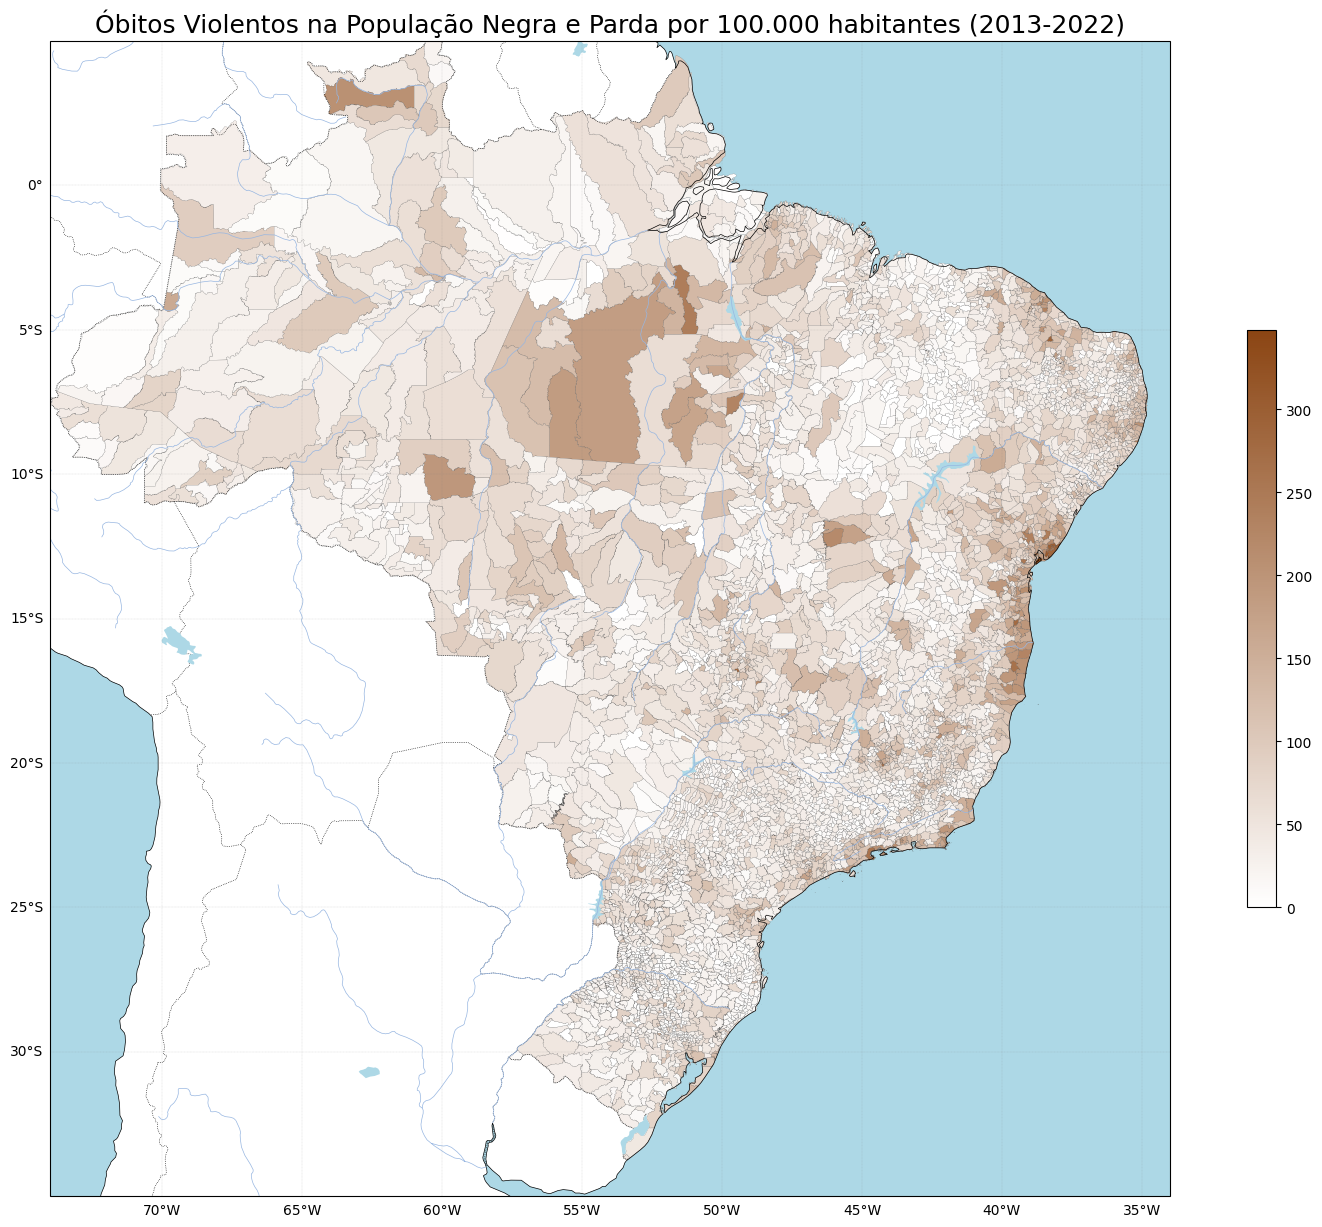

In [34]:
# Calcular o número de óbitos por município
df_obitos_por_municipio = df_limpo.groupBy("CODMUNOCOR").agg(count("*").alias("numero_obitos"))

# Unir os dataframes
df_resultado = df_obitos_por_municipio.join(df_demografia_agg, on="CODMUNOCOR", how="inner")

# Calcular a taxa de mortalidade por 100.000 habitantes
df_resultado = df_resultado.withColumn(
    "taxa_mortalidade",
    round((col("numero_obitos") / col("populacao_total")) * 100000, 2)
)

# Converter para Pandas
df_mortalidade_municipios = df_resultado.select(
    "CODMUNOCOR",
    "nome_local",
    "taxa_mortalidade"
).toPandas()
df_mortalidade_municipios['CODMUNOCOR'] = df_mortalidade_municipios['CODMUNOCOR'].astype(str).str.zfill(6)

# Carregar o shapefile dos municípios
import geopandas as gpd
from geobr import read_municipality

mapa_municipios = read_municipality(year=2020)
mapa_municipios['CODMUNOCOR'] = mapa_municipios['code_muni'].astype(str).str.zfill(7).str[:6]

# Mesclar os dados geográficos com a mortalidade
mapa_mortalidade = mapa_municipios.merge(df_mortalidade_municipios, on='CODMUNOCOR', how='left')
mapa_mortalidade['taxa_mortalidade'] = mapa_mortalidade['taxa_mortalidade'].fillna(0)


# Configurar colormap amarronzado
colors = ["#FFFFFF", "#8B4513"]  # Branco a marrom
brown_cmap = LinearSegmentedColormap.from_list("BrownGradient", colors)


# Definir a projeção
proj = ccrs.PlateCarree()

# Criar a figura e o eixo
fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection=proj)

# Plotar os dados
mapa_mortalidade.plot(
    column='taxa_mortalidade',
    cmap=brown_cmap,
    linewidth=0.1,
    ax=ax,
    edgecolor='0.2'
)

# Adicionar detalhes ao mapa
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# Adicionar gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Ajustar a extensão do mapa para o Brasil
ax.set_extent([-74, -34, -35, 5], crs=proj)

# Adicionar título
plt.title('Óbitos Violentos na População Negra e Parda por 100.000 habitantes (2013-2022)', fontsize=18)

# Adicionar colorbar com escala ajustada
vmin = mapa_mortalidade['taxa_mortalidade'].min()
vmax = mapa_mortalidade['taxa_mortalidade'].max()
sm = plt.cm.ScalarMappable(cmap=brown_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)


# Mostrar o mapa
plt.show()


# Parte IX : Média de Óbitos por causas violentas na população negra e parda nos intervalos: 1 minuto, 30 minutos, 1 hora, e diário

In [51]:
from pyspark.sql import functions as F

# Filtrar os dados para o intervalo de 2012 a 2022
df_filtrado = df_limpo.filter(
    (F.year(F.col("DTOBITO")) >= 2012) & (F.year(F.col("DTOBITO")) <= 2022)
)

# Calcular a data mínima e máxima dentro do intervalo
primeira_data = df_filtrado.agg(F.min("DTOBITO")).collect()[0][0]
ultima_data = df_filtrado.agg(F.max("DTOBITO")).collect()[0][0]

# Calcular o tempo total em segundos
tempo_total_segundos = (ultima_data - primeira_data).total_seconds()

# Contar o número total de óbitos no intervalo
total_obitos = df_filtrado.count()

# Calcular as médias
media_por_hora = total_obitos / (tempo_total_segundos / 3600)
media_por_dia = total_obitos / (tempo_total_segundos / 86400)
media_por_30_min = total_obitos / (tempo_total_segundos / 1800)
media_por_minuto = total_obitos / (tempo_total_segundos / 60)

# Exibir os resultados
resultados = {
    "Média por Hora": media_por_hora,
    "Média por Dia": media_por_dia,
    "Média por 30 Minutos": media_por_30_min,
    "Média por Minuto": media_por_minuto
}

print(resultados)


{'Média por Hora': 3.610723089564503, 'Média por Dia': 86.65735414954807, 'Média por 30 Minutos': 1.8053615447822515, 'Média por Minuto': 0.06017871815940838}
